In [1]:
import sys
sys.path.append('..')

import os

import numpy as np
import pydicom
import matplotlib.pyplot as plt

from ipywidgets.widgets import interact
import ipywidgets as widgets

from visualiser import Patient

In [2]:
patient_path = '../data/1/'
patient = Patient(patient_path)

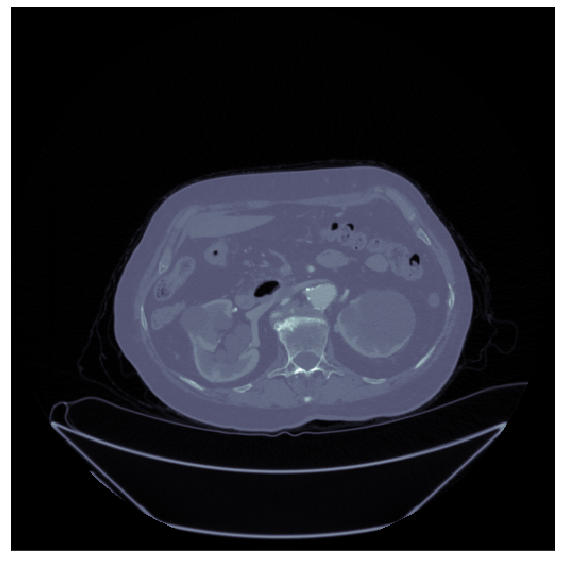

In [3]:
# Static plot
patient.horizontal_plot(z=1500)

In [4]:
# Interactive plot
interact(patient.horizontal_plot, z=(0, patient.shape[0]-1))

interactive(children=(IntSlider(value=858, description='z', max=1717), Output()), _dom_classes=('widget-intera…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

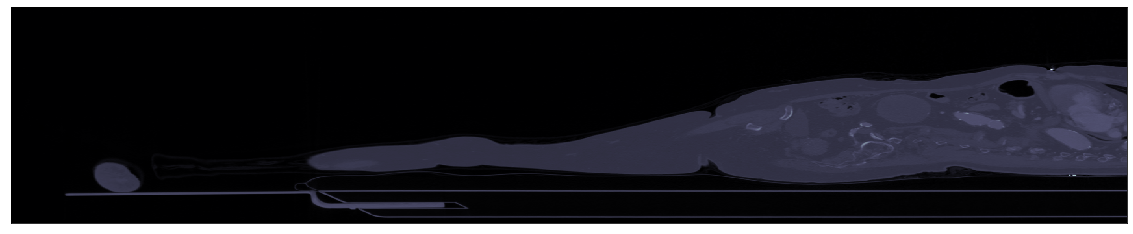

In [5]:
patient.longitudinal_plot(x=300)

In [6]:
interact(patient.longitudinal_plot, x=(0, patient.shape[2]-1))

interactive(children=(IntSlider(value=255, description='x', max=511), Output()), _dom_classes=('widget-interac…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

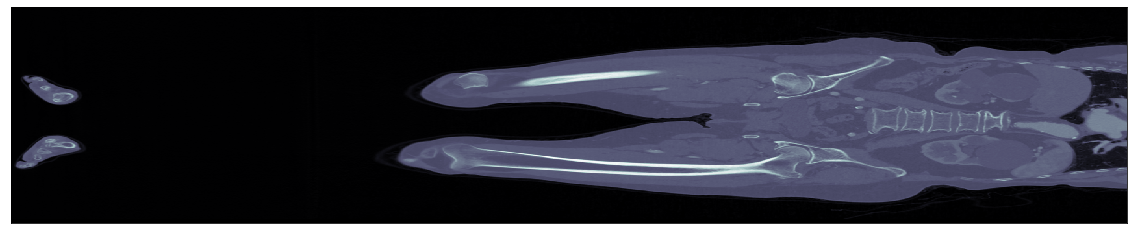

In [7]:
patient.frontal_plot(y=300)

In [8]:
interact(patient.frontal_plot, y=(0, patient.shape[1]-1))

interactive(children=(IntSlider(value=255, description='y', max=511), Output()), _dom_classes=('widget-interac…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [ ]:
print(patient.shape)
patient.resample([1, 1, 1])     # Take long time
print(patient.shape)

(1718, 512, 512)
